# Date: 9 2022
# Method: Cross_Inception
# Data: Pavia
# Results v.05

In [72]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.decomposition import PCA


In [73]:
# Read dataset Pavia
from scipy.io import loadmat

def read_HSI():
  X = loadmat('PaviaU.mat')['paviaU']
  y = loadmat('PaviaU_gt.mat')['paviaU_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (610, 340, 103)
y shape: (610, 340)


In [74]:
# PCA
def applyPCA(X, numComponents): # numComponents=64
    newX = np.reshape(X, (-1, X.shape[2]))
    print(newX.shape)
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca, pca.explained_variance_ratio_

In [75]:
# channel_wise_shift
def channel_wise_shift(X,numComponents):
    X_copy = np.zeros((X.shape[0] , X.shape[1], X.shape[2]))
    half = int(numComponents/2)
    for i in range(0,half-1):
        X_copy[:,:,i] = X[:,:,(half-i)*2-1]
    for i in range(half,numComponents):
        X_copy[:,:,i] = X[:,:,(i-half)*2]
    X = X_copy
    return X

In [76]:
# Split the hyperspectral image into patches of size windowSize-by-windowSize pixels
def Patches_Creating(X, y, windowSize, removeZeroLabels = True):  # windowSize=15, 25
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]),dtype="float16")
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]),dtype="float16")
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
# pading With Zeros
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]),dtype="float16")
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [77]:
# Split Data
from sklearn.model_selection import train_test_split

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,stratify=y)
    return X_train, X_test, y_train, y_test

In [78]:
test_ratio = 0.5

# Load and reshape data for training
X0, y0 = read_HSI()
#X=X0
#y=y0

windowSize=7
width = windowSize
height = windowSize
img_width, img_height, img_num_channels = windowSize, windowSize, 3

input_image_size=windowSize
INPUT_IMG_SIZE=windowSize

dimReduction=3

InputShape=(windowSize, windowSize, dimReduction)

#X, y = loadData(dataset) channel_wise_shift
X1,pca,ratio = applyPCA(X0,numComponents=dimReduction)
X2_shifted = channel_wise_shift(X1,dimReduction) # channel-wise shift
#X2=X1

#print(f"X0 shape: {X0.shape}\ny0 shape: {y0.shape}")
#print(f"X1 shape: {X1.shape}\nX2 shape: {X2.shape}")

X3, y3 = Patches_Creating(X2_shifted, y0, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X3, y3, test_ratio)


X shape: (610, 340, 103)
y shape: (610, 340)
(207400, 103)


In [79]:
# Compile the model
#incept_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
print()

import warnings
warnings.filterwarnings("ignore")

# load libraries
from keras.initializers import VarianceScaling
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
import numpy as np



In [81]:
# 9 classes names
names = ['1. Asphalt', '2. Meadows', '3. Gravel', '4. Trees', 
                 '5. Painted metal sheets','6. Bare Soil', '7. Bitumen', 
                 '8. Self-Blocking Bricks', '9. Shadows']

In [82]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')


def build_model(num_classes):
    inputs = layers.Input(shape=(windowSize, windowSize, 3))
    #x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False,  input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(9, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [83]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [84]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
250/250 - 10s - loss: 1.3724 - accuracy: 0.5216 - val_loss: 1.6878 - val_accuracy: 0.4270 - 10s/epoch - 38ms/step
Epoch 2/20
250/250 - 5s - loss: 1.2106 - accuracy: 0.5564 - val_loss: 1.2848 - val_accuracy: 0.4995 - 5s/epoch - 22ms/step
Epoch 3/20
250/250 - 5s - loss: 1.1822 - accuracy: 0.5696 - val_loss: 1.0464 - val_accuracy: 0.5930 - 5s/epoch - 21ms/step
Epoch 4/20
250/250 - 5s - loss: 1.1440 - accuracy: 0.5786 - val_loss: 1.0101 - val_accuracy: 0.6040 - 5s/epoch - 22ms/step
Epoch 5/20
250/250 - 5s - loss: 1.1183 - accuracy: 0.5853 - val_loss: 0.9806 - val_accuracy: 0.6085 - 5s/epoch - 21ms/step
Epoch 6/20
250/250 - 5s - loss: 1.1138 - accuracy: 0.5878 - val_loss: 0.9632 - val_accuracy: 0.6200 - 5s/epoch - 21ms/step
Epoch 7/20
250/250 - 5s - loss: 1.0992 - accuracy: 0.5910 - val_loss: 0.9359 - val_accuracy: 0.6385 - 5s/epoch - 21ms/step
Epoch 8/20
250/250 - 5s - loss: 1.0914 -

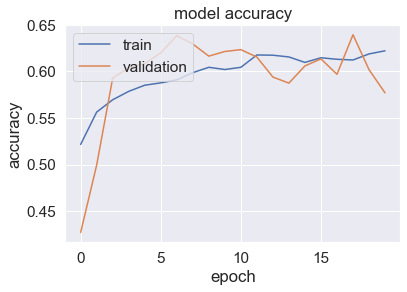

Score for fold 1: loss of 0.9911941885948181; accuracy of 57.70000219345093%
63/63 [==============================] - 2s 17ms/step
[[ 71 158  50   0   0   0   7   1   0]
 [  2 728   8 115   0   1   0   0   0]
 [  0  13  85   0   0   0   0   0   0]
 [  0   0   0 156   0   0   1   0   0]
 [  0   0   0   0  67   0   0   0   0]
 [  1 175  47   0   0   2   0   3   0]
 [ 21   7  16   3   0   1  17   0   0]
 [  2   8 180   0   0   1   1   3   0]
 [  2   3   0  19   0   0   0   0  25]]
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/20
250/250 - 9s - loss: 1.3948 - accuracy: 0.5090 - val_loss: 1.6186 - val_accuracy: 0.4395 - 9s/epoch - 36ms/step
Epoch 2/20
250/250 - 5s - loss: 1.2291 - accuracy: 0.5549 - val_loss: 1.2611 - val_accuracy: 0.5035 - 5s/epoch - 20ms/step
Epoch 3/20
250/250 - 5s - loss: 1.1757 - accuracy: 0.5689 - val_loss: 1.0335 - val_accuracy: 0.6095 - 5s/epoch - 20ms/step
Epoch 4/20
250/250 - 5s - loss: 1.1426 - accuracy: 

<Figure size 432x288 with 0 Axes>

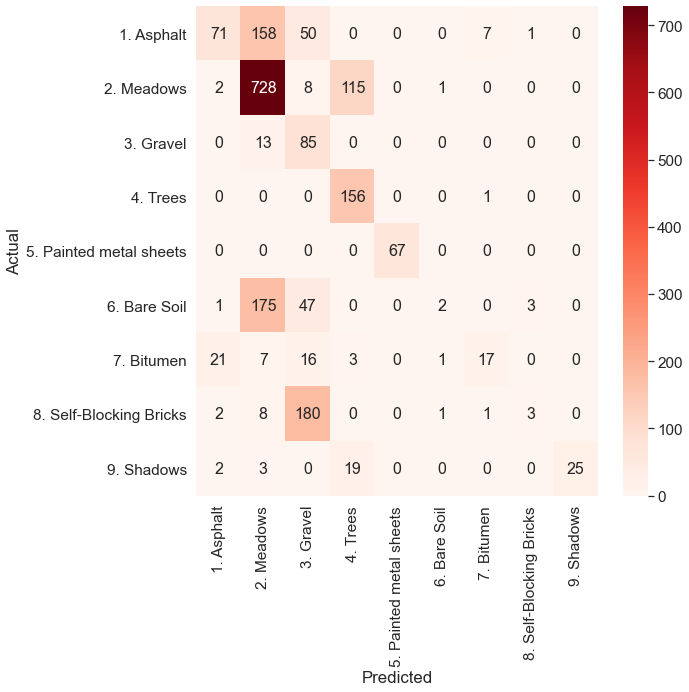

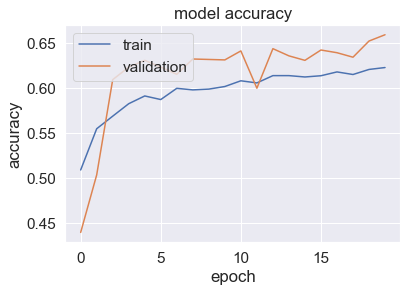

Score for fold 2: loss of 0.9212722182273865; accuracy of 65.9500002861023%
63/63 [==============================] - 3s 20ms/step
[[129 102  14   0   0   0  18  19   0]
 [ 13 747   0 111   0   8   0   0   0]
 [  1  14  36   0   0   1   0  43   0]
 [  0   1   0 137   0   0   1   1   0]
 [  0   0   0   0  72   0   0   0   0]
 [  8 190   9   0   0  31   0  10   0]
 [ 31   8   3   3   0   1  21   6   0]
 [  3   7  37   0   0   4   2 126   0]
 [  0   0   0  12   0   0   0   0  20]]
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/20
250/250 - 10s - loss: 1.4050 - accuracy: 0.5055 - val_loss: 1.6490 - val_accuracy: 0.4380 - 10s/epoch - 38ms/step
Epoch 2/20
250/250 - 5s - loss: 1.2201 - accuracy: 0.5494 - val_loss: 1.2867 - val_accuracy: 0.4895 - 5s/epoch - 22ms/step
Epoch 3/20
250/250 - 5s - loss: 1.1759 - accuracy: 0.5694 - val_loss: 1.0266 - val_accuracy: 0.5925 - 5s/epoch - 22ms/step
Epoch 4/20
250/250 - 5s - loss: 1.1462 - accuracy:

<Figure size 432x288 with 0 Axes>

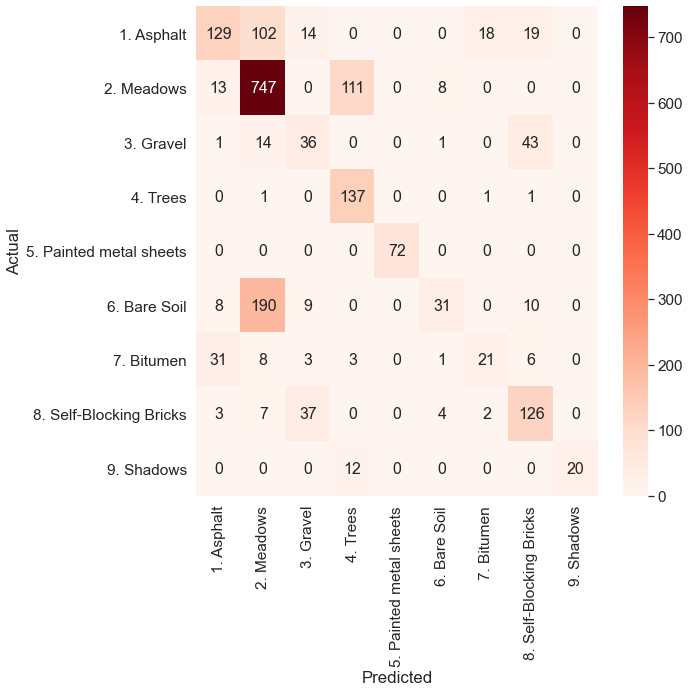

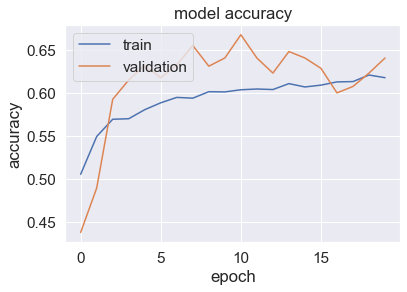

Score for fold 3: loss of 0.9703017473220825; accuracy of 64.0500009059906%
63/63 [==============================] - 2s 17ms/step
[[113 103  29   8   0   1  31  21   0]
 [  8 711   2 138   0  17   0   0   0]
 [  0  13  50   1   0   0   0  41   0]
 [  2   2   0 157   0   0   0   1   0]
 [  0   0   0   0  52   0   0   0   0]
 [  5 161  23   0   0  28   0   8   0]
 [ 31   1   3   2   0   0  20   0   0]
 [  1   3  39   0   0   2   1 122   0]
 [  0   0   0  21   0   0   0   0  28]]
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/20
250/250 - 9s - loss: 1.4021 - accuracy: 0.5145 - val_loss: 1.6166 - val_accuracy: 0.4385 - 9s/epoch - 37ms/step
Epoch 2/20
250/250 - 5s - loss: 1.2212 - accuracy: 0.5484 - val_loss: 1.2386 - val_accuracy: 0.5105 - 5s/epoch - 21ms/step
Epoch 3/20
250/250 - 5s - loss: 1.1667 - accuracy: 0.5692 - val_loss: 1.0128 - val_accuracy: 0.6195 - 5s/epoch - 21ms/step
Epoch 4/20
250/250 - 5s - loss: 1.1476 - accuracy: 0

<Figure size 432x288 with 0 Axes>

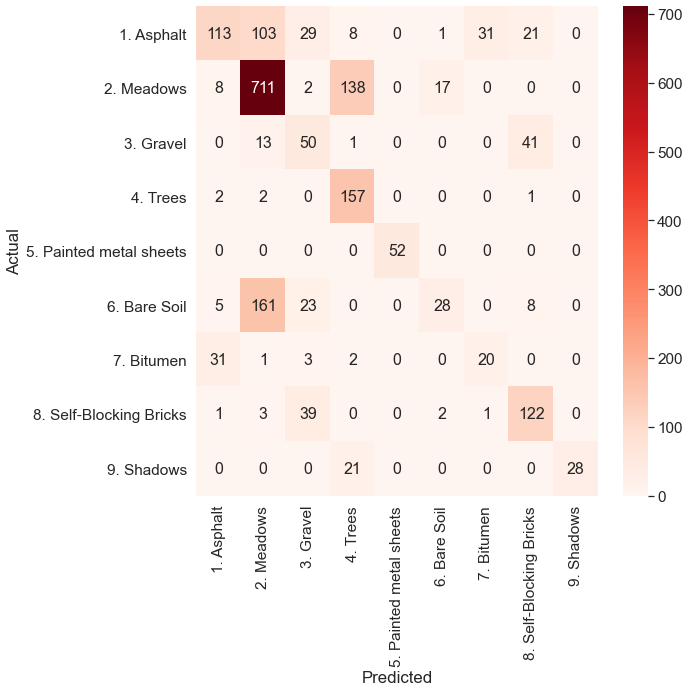

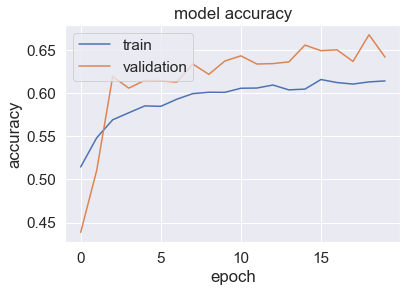

Score for fold 4: loss of 0.9362145662307739; accuracy of 64.20000195503235%
63/63 [==============================] - 2s 17ms/step
[[124 149  14   0   0   0   0  20   0]
 [  6 762   0 109   0   0   0   0   0]
 [  0  13  73   0   0   0   0  25   0]
 [  2   1   0 135   0   1   0   0   0]
 [  0   0   0   0  64   0   0   0   0]
 [  6 179  38   0   0  11   0  12   0]
 [ 36   9   0   2   0   0   6   6   0]
 [  2   3  56   0   0   1   3 101   0]
 [  0   4   0  19   0   0   0   0   8]]
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/20
250/250 - 9s - loss: 1.3981 - accuracy: 0.5142 - val_loss: 1.6358 - val_accuracy: 0.4160 - 9s/epoch - 38ms/step
Epoch 2/20
250/250 - 5s - loss: 1.2217 - accuracy: 0.5552 - val_loss: 1.2696 - val_accuracy: 0.5235 - 5s/epoch - 22ms/step
Epoch 3/20
250/250 - 5s - loss: 1.1622 - accuracy: 0.5726 - val_loss: 1.0295 - val_accuracy: 0.5905 - 5s/epoch - 21ms/step
Epoch 4/20
250/250 - 5s - loss: 1.1442 - accuracy: 

<Figure size 432x288 with 0 Axes>

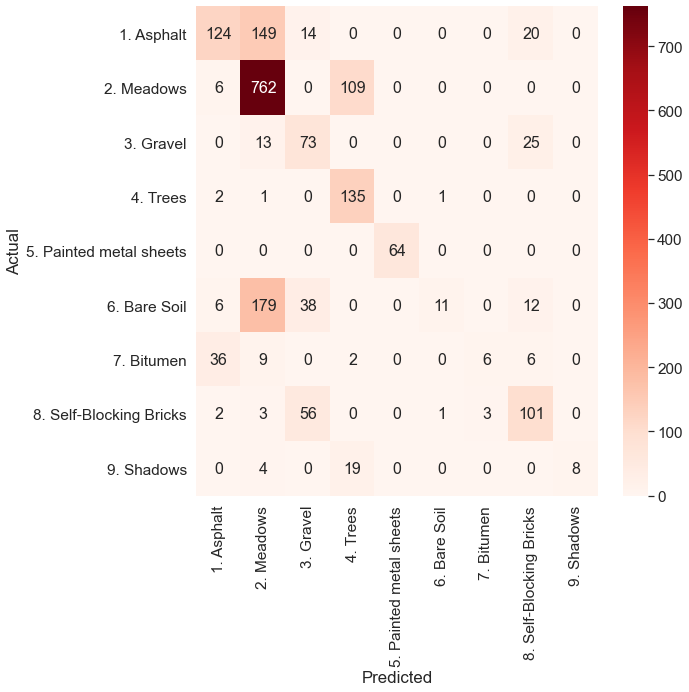

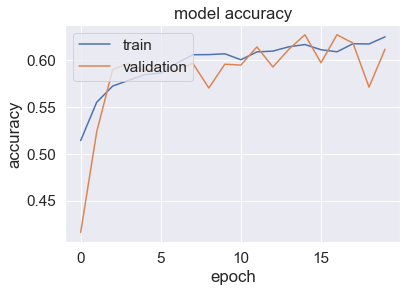

Score for fold 5: loss of 0.9892532229423523; accuracy of 61.19999885559082%
63/63 [==============================] - 2s 17ms/step
[[106 147  36   1   0   1  12  24   0]
 [  7 695   5 119   0   6   0   0   0]
 [  0  13  49   0   0   0   0  26   0]
 [  2   1   0 138   0   0   0   0   1]
 [  0   0   0   0  75   0   0   0   0]
 [  3 188  36   0   0  10   0  13   0]
 [ 25   5   8   3   0   0  15   3   0]
 [  5   6  57   0   0   1   1 119   0]
 [  0   0   0  21   0   0   0   0  17]]
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9911941885948181 - Accuracy: 57.70000219345093%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9212722182273865 - Accuracy: 65.9500002861023%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9703017473220825 - Accuracy: 64.0500009059906%
-----------

<Figure size 432x288 with 0 Axes>

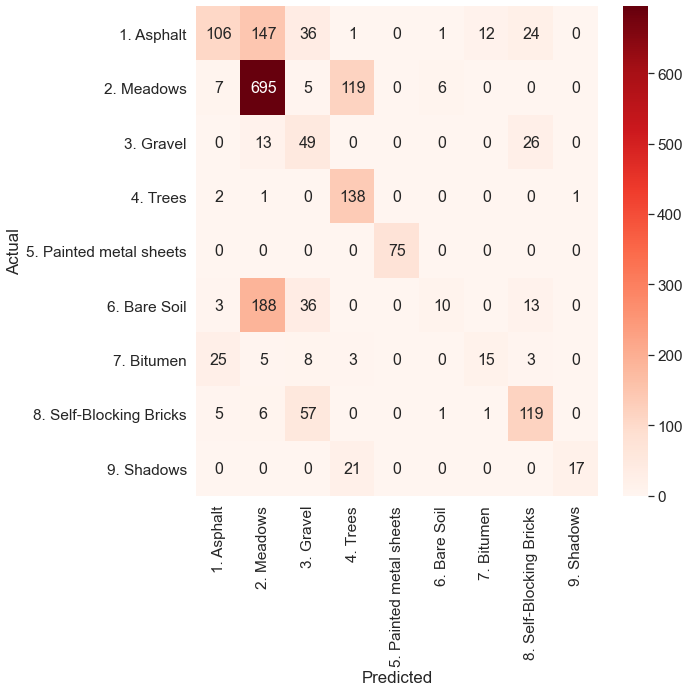

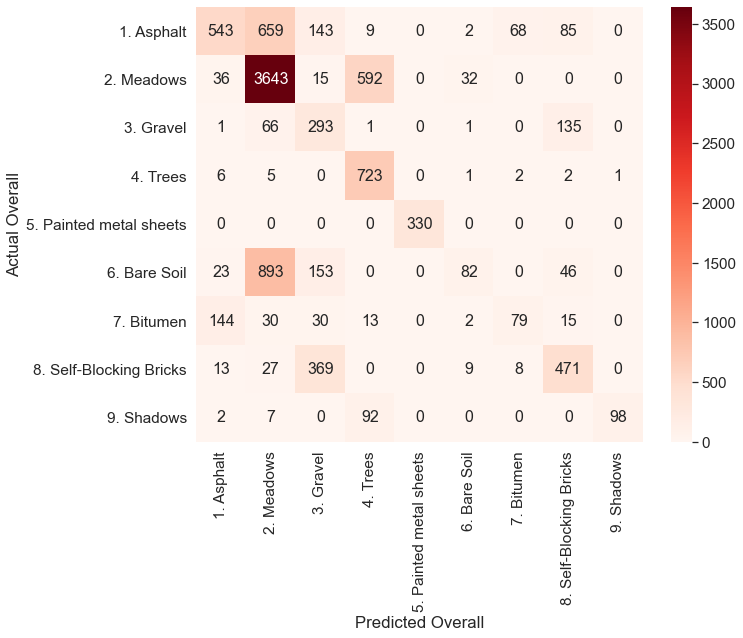

In [85]:

from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras import layers

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model

import tensorflow as tf

# configuration
confmat = 0
batch_size = 50
loss_function = sparse_categorical_crossentropy
no_classes = 9
no_epochs = 20
optimizer = Adam()
verbosity = 1
num_folds = 5

NN=len(Xtrain)
NN=5000

input_train=Xtrain[0:NN]
target_train=ytrain[0:NN]

input_test=Xtest[0:NN]
target_test=ytest[0:NN]

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
#input_train = input_train.astype('float32')
#input_test = input_test.astype('float32')

# Normalize data
#input_train = input_train / 255
#input_test = input_test / 255

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

Y_pred=[]
y_pred=[]
# Merge inputs and targets
inputs = np.concatenate((input_train, input_test), axis=0)
targets = np.concatenate((target_train, target_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  #  model architecture

  # Compile the model
  #model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

   # Compile the model
 # model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

  model = build_model(num_classes=9)
  #model.compile(loss=loss_function, optimizer='rmsprop',metrics=['accuracy'])

  #model.summary()

  #unfreeze_model(model)
  model.compile(loss=loss_function, optimizer='rmsprop',metrics=['accuracy'])



  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  #model.summary()
  
  history = model.fit(inputs[train], targets[train],
              validation_data = (inputs[test],targets[test]),
              epochs=no_epochs,verbose=2 )
  plt.figure()
  plot_hist(history)
 # hist = model.fit(inputs[train], targets[train],
   #                 steps_per_epoch=(29943/batch_size),
   #                 epochs=5,
   #                 validation_data=(inputs[test],targets[test]),
   #                 validation_steps=(8000/batch_size),
   #                 initial_epoch=20,
   #                 verbose=1 )
  plt.figure()
    


  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test],verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # confusion_matrix
  Y_pred = model.predict(inputs[test])
  y_pred = np.argmax(Y_pred, axis=1)
  #target_test=targets[test]

  confusion = confusion_matrix(targets[test], y_pred)
  df_cm = pd.DataFrame(confusion, columns=np.unique(names), index = np.unique(names))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (9,9))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
  plt.savefig('cmap.png', dpi=300)
  print(confusion_matrix(targets[test], y_pred))

  confmat    = confmat + confusion; 
  

  # Increase fold number
  fold_no = fold_no + 1

# == average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Overall_Conf = pd.DataFrame(confmat, columns=np.unique(names), index = np.unique(names))
Overall_Conf.index.name = 'Actual Overall'
Overall_Conf.columns.name = 'Predicted Overall'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(Overall_Conf, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)
print(Overall_Conf)
